# SRGAN: 图像超分算法

单张图像超分辨率技术（SISR，Single image super-resolution），指给定单张低分辨率图像，利用相关技术实现到高分辨图像的重建。常见方法有基于插值的、基于重构的和基于学习的方法。

[SRGAN](https://arxiv.org/abs/1609.04802/)算法基于生成对抗网络，通过引入一个描述感知相似性（Perceptual Similarity）的感知损失函数（Preceptual Loss Function），可以在较高的上采样率下，较好的实现对高频细节（如纹理）的重建。

## 模型简介

SRGAN的生成网络采用SRResNet网络，该网络基于残差块构建，其中引入了一个横跨主干网络的跳跃链接（Skip Connection）以解决训练过程中梯度的爆炸和消失问题。其判别网络含8个卷积层，结构与VGG网络相似。损失函数基于VGG网络特征图构造，相比基于像素间差异构造的损失函数，训练结果更为真实。

论文[1]中针对SRGAN与主流图像超分算法做了对比实验，评价指标如下：

1. 峰值信噪比（PSNR, Peak Signal to Noise Ratio）

> PSNR描述两个图像在每一个位置上的像素值的差异的平均值。

2. 结构相似性(SSIM, Structural Similarity)

> SSIM描述两个图像之间的相似性，通过关注边缘和纹理相似性来模仿人类感知。

3. 平均主观意见分(MOS, Mean Opinion Score)

> MOS描述人们对超分图像的主观评价。

### 模型性能

将SRGAN与多种主流方法在Set5数据集、Set14数据集和BSD100数据集上进行比较，结果见下图。

![show_images](./images/score.png)

## 预训练模型

在计算感知损失时，SRGAN使用了VGG19来提取高级特征，本案例用到的VGG19预训练模型可以在[这里](https://download.mindspore.cn/model_zoo/converted_pretrained/vgg/)下载，下载后请将其保存至根目录下。

## 数据处理

开始实验之前，请确保本地已经安装了Python环境以及MindSpore Vision套件。

### 数据准备

本案例使用[DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/)数据集作为训练集，请在[这里](https://data.vision.ee.ethz.ch/cvl/DIV2K/)下载Train Data (HR images)和Train Data Track 1 bicubic downscaling x4 (LR images)两个文件。

本案例分别使用[Set5和Set14](http://eprints.imtlucca.it/2412/1/Bevilacqua_2012.pdf)数据集作为验证集和测试集，请在[这里](https://github.com/jbhuang0604/SelfExSR)下载。

其中训练集共计800组数据，验证集共计5组数据，测试集共计14组数据。每组数据包含两张图像： 高分辨率图像(HR)和低分辨率图像(LR)。部分数据集图像如下：

![show_images](./images/DIV2K.jpg)

请将解压后的数据集按如下方式放至'./datasets'下：

```text

.datasets/
    └── DIV2K
    |    ├── HR
    |    └── LR
    └── Set5
    |    ├── HR
    |    └── LR
    └── Set14
         ├── HR
         └── LR
```

### 数据增强

DIV2K数据集有800组数据，数据量较少。因此需要使用旋转、水平翻转和垂直翻转操作对训练数据进行数据增强，具体方式如下:

1. 将每组数据中的LR图像随机裁剪至24x24分辨率, 相应的HR图像裁剪至96x96分辨率。

2. 每组数据分别以0.5，0.5，0.5的概率旋转90度、水平翻转和垂直翻转。

In [1]:
import os
import random
import numpy as np
from PIL import Image

# 创建dataset
class TrainDataset:
    """
    Read the training data file in the specified format.

    Args:
        lr_path (str): The path of low-resolution image.
        gt_path (str): The path of high-resolution image.
        in_memory (bool): Choose whether to load the entire dataset into memory. Default: True.
    """
    def __init__(self, lr_path, gt_path, in_memory=True):
        """init"""
        self.lr_path = lr_path
        self.gt_path = gt_path
        self.in_memory = in_memory
        self.lr_img = sorted(os.listdir(lr_path))
        self.gt_img = sorted(os.listdir(gt_path))
        if in_memory:
            self.lr_img = [np.array(Image.open(os.path.join(self.lr_path, lr)).convert("RGB")).astype(np.float32)
                           for lr in self.lr_img]
            self.gt_img = [np.array(Image.open(os.path.join(self.gt_path, hr)).convert("RGB")).astype(np.float32)
                           for hr in self.gt_img]

    def __len__(self):
        """getlength"""
        return len(self.lr_img)

    def __getitem__(self, i):
        """getitem"""
        img_item = {}
        if self.in_memory:
            gt = self.gt_img[i].astype(np.float32)
            lr = self.lr_img[i].astype(np.float32)

        else:
            gt = np.array(Image.open(os.path.join(self.gt_path, self.gt_img[i])).convert("RGB"))
            lr = np.array(Image.open(os.path.join(self.lr_path, self.lr_img[i])).convert("RGB"))
        img_item['GT'] = (gt / 127.5) - 1.0
        img_item['LR'] = (lr / 127.5) - 1.0
        # crop
        ih, iw = img_item['LR'].shape[:2]
        ix = random.randrange(0, iw -24 + 1)
        iy = random.randrange(0, ih -24 + 1)
        tx = ix * 4
        ty = iy * 4
        img_item['LR'] = img_item['LR'][iy : iy + 24, ix : ix + 24]
        img_item['GT'] = img_item['GT'][ty : ty + (4 * 24), tx : tx + (4 * 24)]
        # augmentation
        hor_flip = random.randrange(0, 2)
        ver_flip = random.randrange(0, 2)
        rot = random.randrange(0, 2)
        if hor_flip:
            temp_lr = np.fliplr(img_item['LR'])
            img_item['LR'] = temp_lr.copy()
            temp_gt = np.fliplr(img_item['GT'])
            img_item['GT'] = temp_gt.copy()
            del temp_lr, temp_gt

        if ver_flip:
            temp_lr = np.flipud(img_item['LR'])
            img_item['LR'] = temp_lr.copy()
            temp_gt = np.flipud(img_item['GT'])
            img_item['GT'] = temp_gt.copy()
            del temp_lr, temp_gt

        if rot:
            img_item['LR'] = img_item['LR'].transpose(1, 0, 2)
            img_item['GT'] = img_item['GT'].transpose(1, 0, 2)

        img_item['GT'] = img_item['GT'].transpose(2, 0, 1).astype(np.float32)
        img_item['LR'] = img_item['LR'].transpose(2, 0, 1).astype(np.float32)
        return  img_item['LR'], img_item['GT']

### 数据加载

通过数据集加载接口加载数据集，并转换为Tensor以备输入模型。

In [2]:
from src.dataset.create_loader import create_train_dataloader, create_test_dataloader

# 训练集路径
train_lr_path = './datasets/DIV2K/LR/'
train_hr_path = './datasets/DIV2K/HR/'

# 验证集路径
val_lr_path = './datasets/Set5/LR/'
val_gt_path = './datasets/Set5/HR/'

# 生成dataset
train_ds = create_train_dataloader(batchsize=3, lr_path=train_lr_path, gt_path=train_hr_path, \
    rank_id=0, device_num=2)
val_ds = create_test_dataloader(batchsize=1, lr_path=val_lr_path, gt_path=val_gt_path)

# 生成dataloader
train_data_loader = train_ds.create_dict_iterator()
val_data_loader = val_ds.create_dict_iterator()

### 训练样本可视化

运行以下代码观察经裁剪、数据增强后的训练图片。可以发现图片经过了裁剪、数据增强和归一化处理，并且图片的shape也已经转换为待输入网络的（N，C，H，W）格式，其中N代表样本数量，C代表图片通道，H和W代表图片的高和宽。

Batch shape: (3, 3, 96, 96)


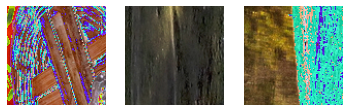

In [3]:
import matplotlib.pyplot as plt

train_sample = next(train_data_loader)
train_sample = train_sample['HR'].asnumpy()
print(f'Batch shape: {train_sample.shape}')

plt.figure()

# 展示图片供参考
for i in range(1, 4):
    plt.subplot(1, 3, i)

    # 将图片转换HWC格式
    image_trans = np.transpose(train_sample[i - 1], (2, 1, 0))

    plt.imshow((image_trans * 255).astype(np.uint8))
    plt.axis("off")

## 网络结构

SRGAN通过生成对抗的方式训练SRResNet，通过引入VGG损失，使其生成的超分辨率图像更加自然，有更好的视觉效果。

### 生成器

SRResNet网络的结构如下：

![network](./images/generator.jpg)

图中k为卷积核尺寸，n为输出通道数，s为步长。B个残差块后接了两个上采样块，上采样块中的PixelShuffler x2将输入特征图的长宽扩大一倍，最终实现四倍的上采样。

In [4]:
import math
import mindspore.nn as nn
import mindspore.ops as ops

class ResidualBlock(nn.Cell):
    """
    Structure of ResidualBlock.

    Args:
        channels: (int): The number of channels.

    Inputs:
        - **x** (Tensor) - The output of the PReLU(close to the first conv layer) or the last residual blocks. The input
          shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **out** (Tensor) - The ResidualBlock output. The output has the shape (batchsize, num_channels, height,
          width).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, has_bias=True, pad_mode='pad')
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, has_bias=True, pad_mode='pad')
        self.bn2 = nn.BatchNorm2d(channels)

    def construct(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + x
        return out

class SubpixelConvolutionLayer(nn.Cell):
    """
    Structure of SubpixelConvolutionLayer.

    Args:
        channels: (int): The number of channels.

    Inputs:
        - **x** (Tensor) - The output of the element-wise-sum or sub-pixel convolution layer.
          The input shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **out** (Tensor) - The SubpixelConvolutionLayer output.
          The output has the shape (batchsize, num_channels, height, width).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, channels):
        super(SubpixelConvolutionLayer, self).__init__()
        self.conv = nn.Conv2d(channels, channels*4, kernel_size=3, stride=1, padding=1, has_bias=True, pad_mode='pad')
        self.pixel_shuffle = ops.DepthToSpace(2)
        self.prelu = nn.PReLU(channels)

    def construct(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.prelu(out)
        return out

class Generator(nn.Cell):
    """
    Structure of Generator.

    Args:
        upscale_factor (int): Upsampling factor of SRGAN.

    Inputs:
        - **x** (Tensor) - The image data.
          The input shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **out** (Tensor) - The generation result.
          The output has the shape (batchsize, num_channels, height, width).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, upscale_factor):

        super(Generator, self).__init__()
        # Calculating the number of subpixel convolution layers.
        num_subpixel_convolution_layers = int(math.log(upscale_factor, 2))
        # First layer.
        self.conv1 = nn.SequentialCell(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4, has_bias=True, pad_mode='pad'),
            nn.PReLU(channel=64))

        # 16 Residual blocks.
        trunk = []
        for _ in range(16):
            trunk.append(ResidualBlock(64))
        self.trunk = nn.SequentialCell(*trunk)

        # Second conv layer post residual blocks.
        self.conv2 = nn.SequentialCell(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, has_bias=True, pad_mode='pad'),
            nn.PReLU(channel=64)
        )

        # 2 Sub-pixel convolution layers.
        subpixel_conv_layers = []
        for _ in range(num_subpixel_convolution_layers):
            subpixel_conv_layers.append(SubpixelConvolutionLayer(64))
        self.subpixel_conv = nn.SequentialCell(*subpixel_conv_layers)

        # Final output layer.
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4, has_bias=True, pad_mode='pad')
        self.tanh = nn.Tanh()

    def construct(self, x):
        conv1 = self.conv1(x)
        trunk = self.trunk(conv1)
        conv2 = self.conv2(trunk)
        out = conv1+conv2
        out = self.subpixel_conv(out)
        out = self.conv3(out)
        out = self.tanh(out)
        return out

### 判别器

判别网络用于判断输入图像为生成网络生成的超分辨率图像，还是数据集中的原图像，其结构如下：

![network](./images/discriminator.jpg)

作者受到其他文献的启发，在判别网络中引入了LeakyReLU而没有引入Max-Pooling。

In [5]:
class Discriminator(nn.Cell):
    """
    Structure of Discriminator.

    Args:
        imgae_size (int): The size of training image.

    Inputs:
        - **x** (Tensor) - The image data. The input shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **out** (Tensor) - The discrimination result. The output has the shape (batchsize, result).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        feature_map_size = int(image_size // 16)
        self.features = _make_layer(conv2d_cfg)
        self.flatten = nn.Flatten()
        self.classifier = nn.SequentialCell(
            nn.Dense(512 * feature_map_size * feature_map_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dense(1024, 1),
            nn.Sigmoid()
        )

    def construct(self, x):
        out = self.features(x)
        out = self.flatten(out)
        out = self.classifier(out)
        return out

def _make_layer(cfg):
    """
    Make stage network of discriminator.

    Args:
        cfg (dict): The number of channels of each layer.

    Returns:
        nn.SequentialCell, Stage network of discriminator.
    """

    layers = []
    stride_add = 0

    for chan_in, chan_out in zip(cfg["in"], cfg["out"]):
        conv2d = nn.Conv2d(chan_in, chan_out, kernel_size=3, stride=1+stride_add, padding=1, pad_mode='pad')
        layers += [conv2d, nn.LeakyReLU(0.2)]
        stride_add = (stride_add + 1) % 2

    return nn.SequentialCell(layers)

## 损失函数

在SRGAN提出前，多数超分算法的优化目标是使超分图像与原始图像间的均方误差（MSE）最小化。均方误差最小化和峰值信噪比（PSNR）最大化是等价的，而后者又是评价超分算法的重要指标，因此基于MSE最小化得到的超分算法，往往可以生成PSNR很高的超分图像。但是，由于PSNR是从像素层面判断超分图像的质量，不能很好的反应人眼的观感，PSNR较高的图像可能反而局部纹理细节较差，因此需要设计新的损失函数。

SRGAN抛弃了描述像素空间相似性的MSE损失函数，提出了感知损失函数（Perceptual Loss Function），其由内容损失（Content Loss）和对抗损失（Adversarial Loss）两部分组成。损失函数的一般形式如下。

$$
l^{SR} = l_X^{SR}+10^{-3}l_{Gen}^{SR}
\tag{1}
$$

其中$l_X^{SR}$为内容损失，$l_{Gen}^{SR}$为对抗损失。

内容损失$l_X^{SR}$在原始论文中也叫做VGG损失，由预训练VGG19模型某层输出的特征图定义，其一般形式如下。

$$
l_{VGG/i.j}^{SR} = \frac{1}{W_{i,j}H_{i,j}}\sum_{x=1}^{W_{i,j}}\sum_{y=1}^{H_{i,j}}(\phi_{i,j}(I^{HR})_{x,y}-\delta)^2
\tag{2}
$$

$$
\delta = \phi_{i,j}(G_{\theta_G}(I^{LR}))_{x,y}
\tag{3}
$$

其中，$I^{HR}$表示高分辨训练图像，$I^{LR}$为与之对应的低分辨率图像，$G_{\theta_G}$表示网络参数为$\theta_G$的生成网络。函数$\phi_{i,j}$表示在VGG19网络中，第$i$个maxpooling层前的第$j$个卷积层（激活后）输出的特征图，其维度由$W_{i,j}$和$H_{i,j}$表示。

上述预训练VGG19基于ImageNet中的100多万张真实图像训练得到，其高层（high-level）特征图可有效模拟人眼的观感，进而获取原图像与生成图像间的感知相似性（perceptual similarity）。

引入对抗损失可以提高超分图像的真实感，其一般形式如下。

$$
l_{Gen}^{SR} = \sum_{n=1}^N-logD_{\theta_D}(G_{\theta_G}(I^{LR}))
\tag{4}
$$

其中，$D_{\theta_D}(G_{\theta_G}(I^{LR}))$表示$G_{\theta_G}(I^{LR})$被判别网络$D_{\theta_D}$判定为真实高分辨率图像的概率。

最后，我们给出图像间像素级的MSE（或PSNR）损失函数，其一般形式如下。

$$
l_{MSE}^{SR} = \frac{1}{r^2WH}\sum_{x=1}^{rW}\sum_{y=1}^{rH}(I_{x,y}^{HR}-G_{\theta_G}(I^{LR})_{x,y})^2
\tag{5}
$$

其中，$r$表示上采样倍数。

In [6]:
class PSNRLoss(nn.Cell):
    """
    Loss for SRResnet.

    Args:
        generator (nn.Cell): SRResnet.

    Inputs:
        - **hr_img** (Tensor) - The high-resolution image.
          The input shape must be (batchsize, num_channels, height, width).
        - **lr_img** (Tensor) - The low-resolution image.
          The input shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **psnr_loss** (Tensor) - The pixel-wise PSNR(MSE) loss.
          The output has the shape (batchsize, loss_value).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, generator):
        super(PSNRLoss, self).__init__()
        self.generator = generator
        self.pixel_criterion = nn.MSELoss()
    def construct(self, hr_img, lr_img):
        hr = hr_img
        sr = self.generator(lr_img)
        psnr_loss = self.pixel_criterion(hr, sr)
        return psnr_loss

### 生成网络的损失函数

生成网络损失函数的一般形式如下。

$$
l_G = \lambda_{mse}l_{MSE}^{SR} + \lambda_{perc}l_{X}^{SR}+\lambda_{gen}l_{Gen}^{SR}
\tag{5}
$$

其中，系数为相应损失的权重。

In [7]:
import mindspore.common.dtype as mstype
from src.vgg19.define import vgg19
from src.loss.mean_shift import MeanShift

class GeneratorLoss(nn.Cell):
    """
    Loss for generator.

    Args:
        discriminator (nn.Cell): Discriminator network.
        generator (nn.Cell): SRResnet.
        vgg_ckpt (str): The path of vgg19 checkpoint file.

    Inputs:
        - **hr_img** (Tensor) - The high-resolution image.
          The input shape must be (batchsize, num_channels, height, width).
        - **lr_img** (Tensor) - The low-resolution image.
          The input shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **g_loss** (Tensor) -  Generator loss, compose of perception loss, adversarial loss and l2 loss.
          The output has the shape (batchsize, loss_value).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, discriminator, generator, vgg):
        super(GeneratorLoss, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.mse_loss = nn.MSELoss()
        self.adversarial_criterion = nn.BCELoss()
        ones = ops.Ones()
        self.real_lable = ones((16, 1), mstype.float32)
        self.meanshif = MeanShift()
        self.vgg = vgg
        for p in self.meanshif.get_parameters():
            p.requires_grad = False

    def construct(self, hr_img, lr_img):
        """gloss"""
        # L2loss
        sr = self.generator(lr_img)
        l2_loss = self.mse_loss(sr, hr_img)

        # adversarialloss
        fake_output = self.discriminator(sr)
        adversarial_loss = self.adversarial_criterion(fake_output, self.real_lable)

        # vggloss
        hr_img = (hr_img+1.0)/2.0
        sr = (sr+1.0)/2.0
        hr_img = self.meanshif(hr_img)
        sr = self.meanshif(sr)
        hr_feat = self.vgg(hr_img)
        sr_feat = self.vgg(sr)
        percep_loss = self.mse_loss(hr_feat, sr_feat)

        g_loss = 0.006 * percep_loss + 1e-3 * adversarial_loss + l2_loss
        return  g_loss

### 判别网络的损失函数

判别网络的损失函数为二元交叉熵损失函数，其一般形式如下。

$$
l_D = -ylogD(x^{HR})-(1-y)log(1-D(x^{HR}))
\tag{6}
$$

In [8]:
class DiscriminatorLoss(nn.Cell):
    """
    Loss for discriminator.

    Args:
        discriminator (nn.Cell): Discriminator network.
        generator (nn.Cell): SRResnet.

    Inputs:
        - **hr_img** (Tensor) - The high-resolution image.
          The input shape must be (batchsize, num_channels, height, width).
        - **lr_img** (Tensor) - The low-resolution image.
          The input shape must be (batchsize, num_channels, height, width).

    Outputs:
        - **d_loss** (Tensor) -  Binary cross-entropy loss.
          The output has the shape (batchsize, loss_value).

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``
    """
    def __init__(self, discriminator, generator):
        super(DiscriminatorLoss, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.adversarial_criterion = nn.BCELoss()
        ones = ops.Ones()
        zeros = ops.Zeros()
        self.real_lable = ones((16, 1), mstype.float32)
        self.fake_lable = zeros((16, 1), mstype.float32)

    def construct(self, hr_img, lr_img):
        """dloss"""
        # Generating fake high resolution images from real low resolution images.
        sr = self.generator(lr_img)
        # Let the discriminator realize that the sample is real.
        real_output = self.discriminator(hr_img)
        d_loss_real = self.adversarial_criterion(real_output, self.real_lable)
        # Let the discriminator realize that the sample is false.
        fake_output = self.discriminator(sr)
        d_loss_fake = self.adversarial_criterion(fake_output, self.fake_lable)
        d_loss = d_loss_fake+d_loss_real
        return  d_loss

## 模型实现

在之前的工作中，我们定义了数据集接口、网络结构和损失函数，并导入了数据集。下面我们进行模型训练、评估和推理。

### 导入所需包


In [9]:
import os
import argparse
import time

import numpy as np
from skimage.color import rgb2ycbcr
from skimage.metrics import peak_signal_noise_ratio
import mindspore.nn as nn
from mindspore import load_checkpoint, save_checkpoint, load_param_into_net
import mindspore.ops as ops
from mindspore.common import set_seed

from src.model.generator import get_generator
from src.model.discriminator import get_discriminator
from src.dataset.create_loader import create_train_dataloader, create_test_dataloader
from src.loss.psnr_loss import PSNRLoss
from src.loss.gan_loss import DiscriminatorLoss, GeneratorLoss
from src.vgg19.define import vgg19
from src.train.train_psnr import TrainOnestepPSNR
from src.train.train_gan import TrainOneStepD, TrainOnestepG

### 设置训练参数

In [10]:
def parse_args():
    """Add argument"""
    parser = argparse.ArgumentParser(description="SRGAN train")
    parser.add_argument("--train_LR_path", default='./datasets/DIV2K/LR', type=str)
    parser.add_argument("--train_GT_path", default='./datasets/DIV2K/HR', type=str)
    parser.add_argument("--val_LR_path", default='./datasets/Set5/LR', type=str)
    parser.add_argument("--val_GT_path", default='./datasets/Set5/HR', type=str)
    parser.add_argument("--vgg_ckpt", default='./src/vgg19/vgg19.ckpt', type=str)
    parser.add_argument('--upscale_factor', default=4, type=int, choices=[2, 4, 8],
                        help='super resolution upscale factor')
    parser.add_argument("--image_size", type=int, default=96,
                        help="Image size of high resolution image. (default: 96)")
    parser.add_argument("--train_batch_size", default=16, type=int,
                        metavar="N", help="batch size for training")
    parser.add_argument("--val_batch_size", default=1, type=int,
                        metavar="N", help="batch size for tesing")
    parser.add_argument("--psnr_epochs", default=2, type=int, metavar="N",
                        help="Number of total psnr epochs to run. (default: 2000)")
    parser.add_argument("--start_psnr_epoch", default=0, type=int, metavar='N',
                        help="Manual psnr epoch number (useful on restarts). (default: 0)")
    parser.add_argument("--gan_epochs", default=1, type=int, metavar="N",
                        help="Number of total gan epochs to run. (default: 1000)")
    parser.add_argument("--start_gan_epoch", default=0, type=int, metavar='N',
                        help="Manual gan epoch number (useful on restarts). (default: 0)")
    parser.add_argument('--init_type', type=str, default='normal', choices=("normal", "xavier"), \
                        help='network initialization, default is normal.')
    parser.add_argument("--scale", type=int, default=4)
    parser.add_argument('--platform', type=str, default='Ascend', choices=('Ascend', 'GPU', 'CPU'))
    # distribute
    parser.add_argument("--run_distribute", type=int, default=0, help="Run distribute, default: 0.")
    parser.add_argument("--device_num", type=int, default=1, help="number of device, default: 1.")
    return parser.parse_args(args=[])
args = parse_args()

### 生成器预训练

首先，以像素间的均方误差最小化（即峰值信噪比最大化）为目标，对生成器网络进行预训练。

原论文中进行了2000轮训练，此处仅训练了两轮。

In [11]:
set_seed(2022)
# create dataset
train_ds = create_train_dataloader(args.train_batch_size, args.train_LR_path, args.train_GT_path, 0,
                                   args.device_num)
test_ds = create_test_dataloader(args.val_batch_size, args.val_LR_path, args.val_GT_path)
train_data_loader = train_ds.create_dict_iterator()
test_data_loader = test_ds.create_dict_iterator()

# definition of network
generator = get_generator(4, 0.02)

# network with loss
psnr_loss = PSNRLoss(generator)

# optimizer
psnr_optimizer = nn.Adam(generator.trainable_params(), 1e-4)

# operation for testing
op = ops.ReduceSum(keep_dims=False)

# trainonestep
train_psnr = TrainOnestepPSNR(psnr_loss, psnr_optimizer)
train_psnr.set_train()

bestpsnr = 0
if not os.path.exists("./ckpt"):
    os.makedirs("./ckpt")

# warm up generator
for epoch in range(args.start_psnr_epoch, args.psnr_epochs):
    print("Generator: training {:d} epoch:".format(epoch + 1))
    time_begin = time.time()
    for data in train_data_loader:
        lr = data['LR']
        hr = data['HR']
        mse_loss = train_psnr(hr, lr)
    steps = train_ds.get_dataset_size()
    time_elapsed = time.time() - time_begin
    step_time = time_elapsed / steps
    print('per step needs time:{:.0f}ms'.format(step_time * 1000))
    print("mse_loss:", mse_loss)
    psnr_list = []

    # val for every epoch
    for test in test_data_loader:
        lr = test['LR']
        gt = test['HR']

        _, _, h, w = lr.shape[:4]
        gt = gt[:, :, : h * args.scale, : w * args.scale]

        output = generator(lr)
        output = op(output, 0)
        output = output.asnumpy()
        output = np.clip(output, -1.0, 1.0)
        gt = op(gt, 0)

        output = (output + 1.0) / 2.0
        gt = (gt + 1.0) / 2.0

        output = output.transpose(1, 2, 0)
        gt = gt.asnumpy()
        gt = gt.transpose(1, 2, 0)

        y_output = rgb2ycbcr(output)[args.scale: -args.scale, args.scale: -args.scale, :1]
        y_gt = rgb2ycbcr(gt)[args.scale: -args.scale, args.scale: -args.scale, :1]
        psnr = peak_signal_noise_ratio(y_output/255.0, y_gt/255.0, data_range=1.0)
        psnr_list.append(psnr)

    mean = np.mean(psnr_list)
    print("psnr:", mean)
    if mean > bestpsnr:
        bestpsnr = mean
        save_checkpoint(train_psnr, "./ckpt/best.ckpt")
    if (epoch + 1) % 200 == 0:
        save_checkpoint(train_psnr, './ckpt/pre_trained_model_%03d.ckpt' % (epoch + 1))

    print("{:d}/2000 epoch finished".format(epoch + 1))


Generator: training 1 epoch:
per step needs time:2782ms
mse_loss: 0.086579435
psnr: 16.173250877141776
1/2000 epoch finished
Generator: training 2 epoch:
per step needs time:19ms
mse_loss: 0.058492776
psnr: 17.784184582176902
2/2000 epoch finished


### 模型训练

在预训练结束后，利用生成对抗的方式，继续训练生成器。

原论文中进行了1000轮训练，此处仅训练了一轮。

In [12]:
# definition of network
generator = get_generator(4, 0.02)
discriminator = get_discriminator(96, 0.02)

# pretrained model
ckpt = "./ckpt/best.ckpt"
params = load_checkpoint(ckpt)
load_param_into_net(generator, params)
vgg = vgg19(args.vgg_ckpt)

# loss
discriminator_loss = DiscriminatorLoss(discriminator, generator)
generator_loss = GeneratorLoss(discriminator, generator, vgg)

# optimizer
generator_optimizer = nn.Adam(generator.trainable_params(), 1e-4)
discriminator_optimizer = nn.Adam(discriminator.trainable_params(), 1e-4)

# trainonestep
train_discriminator = TrainOneStepD(discriminator_loss, discriminator_optimizer)
train_generator = TrainOnestepG(generator_loss, generator_optimizer)

# trainGAN
for epoch in range(args.start_gan_epoch, args.gan_epochs):
    print('Gan: training {:d} epoch'.format(epoch + 1))
    train_begin = time.time()
    for data in train_data_loader:
        lr = data['LR']
        hr = data['HR']
        d_loss = train_discriminator(hr, lr)
        g_loss = train_generator(hr, lr)
    time_elapsed = time.time() - train_begin
    steps = train_ds.get_dataset_size()
    step_time = time_elapsed / steps
    print('per step needs time:{:.0f}ms'.format(step_time * 1000))
    print("D_loss:", d_loss.mean())
    print("G_loss:", g_loss.mean())

    if (epoch + 1) % 100 == 0:
        save_checkpoint(train_generator, './ckpt/G_model_%03d.ckpt' % (epoch + 1))
        save_checkpoint(train_discriminator, './ckpt/D_model_%03d.ckpt' % (epoch + 1))
    print(" {:d}/1000 epoch finished".format(epoch + 1))

[WARNING] ME(56338:281473340910144,MainProcess):2022-09-07-13:11:24.108.485 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter generator.conv1.0.weight's prefix name: generator., continue to load it to net parameter conv1.0.weight.


Gan: training 1 epoch
per step needs time:3598ms
D_loss: 1.3653828
G_loss: 0.05751312
 1/1000 epoch finished


### 模型评估

在Set5数据集上以峰值信噪比为指标进行评估。峰值信噪比（PSNR, Peak Signal to Noise Ratio）描述两个图像在每一个位置上的像素值的差异的平均值，是图像超分的常用评价指标。

In [13]:
def parse_args():
    """Add argument"""
    parser = argparse.ArgumentParser(description="SRGAN eval")
    parser.add_argument("--test_LR_path", default='./datasets/Set5/LR', type=str)
    parser.add_argument("--test_GT_path", default='./datasets/Set5/HR', type=str)
    parser.add_argument("--res_num", type=int, default=16)
    parser.add_argument("--scale", type=int, default=4)
    parser.add_argument("--generator_path", default='./ckpt/G_model_1000.ckpt', type=str)
    parser.add_argument("--device_id", type=int, default=0, help="device id, default: 0.")
    parser.add_argument('--platform', type=str, default='Ascend', choices=('Ascend', 'GPU', 'CPU'))
    return parser.parse_args(args=[])
args = parse_args()

In [14]:
# 测试集接口
test_ds = create_test_dataloader(1, args.test_LR_path, args.test_GT_path)
test_data_loader = test_ds.create_dict_iterator()

# 构建生成器网络
generator = Generator(4)
params = load_checkpoint(args.generator_path)
print("======load checkpoint")
load_param_into_net(generator, params)

# 模型评估
op = ops.ReduceSum(keep_dims=False)
psnr_list = []
print("=======starting test=====")
for data in test_data_loader:
    lr = data['LR']
    gt = data['HR']
    _, _, h, w = lr.shape[:4]
    gt = gt[:, :, : h * args.scale, : w *args.scale]

    output = generator(lr)
    output = op(output, 0)
    output = output.asnumpy()
    output = np.clip(output, -1.0, 1.0)
    gt = op(gt, 0)

    output = (output + 1.0) / 2.0
    gt = (gt + 1.0) / 2.0

    output = output.transpose(1, 2, 0)
    gt = gt.asnumpy()
    gt = gt.transpose(1, 2, 0)
    y_output = rgb2ycbcr(output)[args.scale:-args.scale, args.scale:-args.scale, :1]
    y_gt = rgb2ycbcr(gt)[args.scale:-args.scale, args.scale:-args.scale, :1]

    psnr = peak_signal_noise_ratio(y_output / 255.0, y_gt / 255.0, data_range=1.0)
    psnr_list.append(psnr)
print("avg PSNR:", np.mean(psnr_list))

[WARNING] ME(56338:281473340910144,MainProcess):2022-09-07-13:12:30.981.999 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter generator.conv1.0.weight's prefix name: generator., continue to load it to net parameter conv1.0.weight.


======load checkpoint
=======starting test=====
avg PSNR: 30.997722005197154


### 模型推理

在Set14数据集上进行推理。

In [15]:
def parse_args():
    """Add argument"""
    parser = argparse.ArgumentParser(description="SRGAN infer")
    parser.add_argument("--test_LR_path", default='./datasets/Set14/LR', type=str)
    parser.add_argument("--scale", type=int, default=4)
    parser.add_argument("--generator_path", default='./ckpt/G_model_1000.ckpt', type=str)
    parser.add_argument("--device_id", type=int, default=0, help="device id, default: 0.")
    parser.add_argument('--platform', type=str, default='Ascend', choices=('Ascend', 'GPU', 'CPU'))
    return parser.parse_args(args=[])
args = parse_args()

In [16]:
# 测试集接口
test_ds = create_test_dataloader(1, args.test_LR_path, inference=True)
data_size = test_ds.get_dataset_size()
test_data_loader = test_ds.create_dict_iterator()

# 构建生成器网络
generator = Generator(args.scale)
params = load_checkpoint(args.generator_path)
print("======load checkpoint")
load_param_into_net(generator, params)

# 推理
op = ops.ReduceSum(keep_dims=False)
print("=======starting test=====")
time_total = 0
i = 0
for data in test_data_loader:
    time_begin = time.time()
    lr = data['LR']
    output = generator(lr)
    time_total += time.time() - time_begin
    output = op(output, 0).asnumpy()
    output = np.clip(output, -1.0, 1.0)
    output = ((output + 1.0) / 2.0).transpose(1, 2, 0)
    result = Image.fromarray((output * 255.0).astype(np.uint8))
    # save the output image
    result.save(f"./output/{i}.jpg")
    i += 1
print("Total %d images need %.0fms, per image needs %.0fms." % (data_size, time_total * 1000, (time_total / data_size) * 1000))
print("Inference End.")

[WARNING] ME(56338:281473340910144,MainProcess):2022-09-07-13:13:23.399.452 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter generator.conv1.0.weight's prefix name: generator., continue to load it to net parameter conv1.0.weight.


======load checkpoint
=======starting test=====
Total 14 images need 103873ms, per image needs 7420ms.
Inference End.


## 总结

本案例对SRGAN模型进行了详细的解释，向读者完整地展现了该算法的流程。

## 引用

[1] Ledig C, et al. Photo-realistic single image super-resolution using a generative adversarial network[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2017: 4681-4690.